In [1]:
import requests
from io import BytesIO
import zipfile
import xmltodict
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from config import *
warnings.filterwarnings(action='ignore')

BasePath = '/Users/yungi/Documents/Dataset/'
crtfc_key = DART_PRIVATE['API_KEY']
api = 'https://opendart.fss.or.kr/api/corpCode.xml'
res = requests.get(api, params={'crtfc_key': crtfc_key})
data_xml = zipfile.ZipFile(BytesIO(res.content))

In [2]:
data_xml = data_xml.read('CORPCODE.xml').decode('utf-8')
data_odict = xmltodict.parse(data_xml)
data_dict = json.loads(json.dumps(data_odict))
data = data_dict.get('result', {}).get('list')

In [3]:
data = pd.DataFrame(data)

In [27]:
GpassComp = pd.read_csv("/Users/yungi/Documents/Dataset/20220213기준_GPASS기업목록_업체명+사업자번호+시작일자+종료일자.csv")

In [28]:
GpassComp['업체명']

0           (주)우드메탈
1          주식회사 토페스
2       주식회사 케이에스아이
3         주식회사 다빈워텍
4         주식회사 디에스엘
           ...     
1016      주식회사 효신테크
1017      호평중공업주식회사
1018       (주)케이에스피
1019      주식회사 대경산전
1020     주식회사 대명콘스텍
Name: 업체명, Length: 1021, dtype: object

In [6]:
GpassComp['업체명'] = GpassComp['업체명'].agg(lambda x: x.split('(주)')[1] if x.startswith('(주)') else x.split('주식회사')[1] if x.startswith('주식회사') else x)

In [7]:
GpassComp['업체명'] = GpassComp['업체명'].agg(lambda x: x.split(' 주식회사')[0] if x.endswith(' 주식회사') else x.split('주식회사')[0] if x.endswith('주식회사') else x)

In [8]:
GpassComp

,업체명,사업자번호,시작일자,종료일자
0,우드메탈,1328128395,2014-03-27,2022-03-26
1,토페스,2078115520,2014-03-27,2022-03-26
2,케이에스아이,4078102931,2014-03-27,2022-03-26
3,다빈워텍,1328179142,2014-03-27,2022-03-26
4,디에스엘,1378141582,2014-03-27,2022-03-26
...,...,...,...,...
1016,효신테크,1378155581,2021-12-17,2026-12-16
1017,호평중공업,4058104758,2021-12-17,2026-12-16
1018,케이에스피,1288174527,2021-12-17,2026-12-16
1019,대경산전,4028164121,2021-12-17,2026-12-16


In [9]:
# TEST - feel free to remove
BasePath = '/Users/yungi/Documents/Dataset/'
pps_data = pd.read_csv(os.path.join(BasePath, '조달기업별_실적_202111.csv'))

In [10]:
# TEST2
NotGpass = pps_data[~pps_data['업체명'].isin(GpassComp['업체명'])].drop(0).reset_index(drop=True)

In [12]:
# NonGPASS 중 DART 등록 회사들만 추려내기
Dart_NonGpass = pd.merge(data, NotGpass.rename(columns={'업체명':'corp_name'}), on=['corp_name'], how='inner')
# NonGPASS기업 + DART 공시대상 + 상장회사 필터링
Dart_NonGpass = Dart_NonGpass[~Dart_NonGpass['stock_code'].isna()].reset_index(drop=True)
# 동일한 이름가진 회사들 걸러내기
SpecCorp = pd.DataFrame(Dart_NonGpass['corp_name'].value_counts())
Dart_NonGpass = Dart_NonGpass[Dart_NonGpass['corp_name'].isin(SpecCorp[SpecCorp['corp_name']==1].index)].reset_index(drop=True)
Dart_NonGpass


,corp_code,corp_name,stock_code,modify_date,전년총건수,전년총금액,당년총건수,당년총금액,증감건수,증감금액
0,00305297,코텍,052330,20211214,0,0.0,2,116930000.0,_,_
1,00106313,금호건설,002990,20210413,3,3001990.0,1,530200.0,-66.67,-82.34
2,00173351,삼진,032750,20211125,1,374000.0,0,0.0,_,_
3,00190321,케이티,030200,20220128,1,17240.0,0,0.0,_,_
4,00300548,현대리바트,079430,20211203,2,983400.0,1,4979700.0,-50.00,406.38
...,...,...,...,...,...,...,...,...,...,...
226,00152260,카스,016920,20211203,0,0.0,1,1430000.0,_,_
227,00131939,선도전기,007610,20211203,0,0.0,3,815300.0,_,_
228,00180795,인팩,023810,20211203,2,49940000.0,0,0.0,_,_
229,00423690,삼성출판사,068290,20211203,1,332640.0,0,0.0,_,_


In [13]:
# DART에 등록되어 있는 공시대상회사 목록에 GPASS기업이 얼마나 등록되어 있는지 확인
target = data[data['corp_name'].isin(GpassComp['업체명'])]
target

,corp_code,corp_name,stock_code,modify_date
492,00255372,센텍,None,20170630
1989,00110325,대성,None,20170630
2324,00192365,대원산업,None,20170630
2786,00172033,경동산업,None,20170630
4065,00818047,대성,None,20170630
...,...,...,...,...
88107,00234722,유천엔바이로,None,20220211
88436,00102353,경창산업,024910,20210709
88622,00667443,동양이앤씨,None,20210510
89149,00226538,대왕철강,None,20211203


In [14]:
SpecCorp = pd.DataFrame(target['corp_name'].value_counts())
# 여러 개 뜨는애들은 분간하기 힘들어서 일단 분석에서 제외!
# 기업이름 유일하게 하나밖에 없는 것만 분석대상에 포함
target = target[target['corp_name'].isin(SpecCorp[SpecCorp['corp_name']==1].index)]
target

,corp_code,corp_name,stock_code,modify_date
4277,00761387,제이엔티,None,20170630
4448,00489580,디앤에스테크놀로지,None,20170630
4911,00589118,에니텍시스,None,20170630
8037,00319494,옥서스,None,20170630
8371,00495350,한길산업,None,20170630
...,...,...,...,...
88107,00234722,유천엔바이로,None,20220211
88436,00102353,경창산업,024910,20210709
88622,00667443,동양이앤씨,None,20210510
89149,00226538,대왕철강,None,20211203


In [15]:
# 재무제표는 주식시장에 상장된 회사 및 기업들만 의무적으로 공개하고 있다.
# Note! DART에 등록된 GPASS기업들 중에서도 상장된 기업이 몇 안됨.
# 즉, 현 상장된 아래 19개 GPASS 기업들에 대해서만 제무재표를 얻을 수 있음..ㅜ
ListedGPASS = target[~target['stock_code'].isna()]
ListedGPASS

,corp_code,corp_name,stock_code,modify_date
53330,00273439,메디아나,041920,20210218
65955,00408266,유니온커뮤니티,203450,20210302
68557,00525864,피앤씨테크,237750,20210428
74191,00362159,웰크론,065950,20210226
74387,00605522,소룩스,290690,20210223
77823,00156150,하이트론씨스템즈,019490,20211213
77856,00632793,전진바이오팜,110020,20210601
78227,00351375,뉴보텍,060260,20211206
78483,00328191,케이에스피,073010,20211206
78549,00140955,한솔케미칼,014680,20211217


In [16]:
import dart_fss as dart

In [17]:
dart.set_api_key(api_key=crtfc_key)

'b6d9af0e4dcbc3874625f5f53acea795dfd3e4d8'

In [18]:
# DART 에 공시된 모든 회사 리스트 불러오기
corp_list = dart.get_corp_list()
# 기업이름 검색
corp = corp_list.find_by_corp_name('웹스', exactly=True)[0]
# bgn_ne연도 부터 재무제표 불러오기
fs = corp.extract_fs(bgn_de='20210101')
df_bs = fs.show('bs', show_class=False)
df_bs.columns = df_bs.columns.droplevel()

Output()

Output()

Output()

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

In [20]:
df_bs

,concept_id,label_ko,label_en,"(연결재무제표,)","(연결재무제표,)","(연결재무제표,)"
0,ifrs-full_CurrentAssets,유동자산,Current assets,"30,902,172,993.0","29,463,001,719.0","26,879,361,054.0"
1,ifrs-full_CashAndCashEquivalents,현금및현금성자산,Cash and cash equivalents,"10,642,254,874.0","12,751,896,086.0","11,156,965,169.0"
2,ifrs-full_TradeAndOtherCurrentReceivables,매출채권 및 기타유동채권,Trade and other current receivables,"4,115,531,900.0","3,255,674,800.0","5,226,871,383.0"
3,ifrs-full_OtherCurrentFinancialAssets,기타유동금융자산,Other current financial assets,"2,874,607,924.0","567,310,486.0","268,934,144.0"
4,dart_OtherCurrentAssets,기타유동자산,Other current assets,"3,155,386,430.0","2,804,867,842.0","2,118,222,413.0"
5,ifrs-full_Inventories,재고자산,Inventories,"10,114,391,865.0","10,083,252,505.0","8,108,367,945.0"
6,ifrs-full_NoncurrentAssets,비유동자산,Non-current assets,"35,980,238,233.0","39,139,444,891.0","40,170,763,837.0"
7,ifrs-full_OtherNoncurrentFinancialAssets,기타비유동금융자산,Other non-current financial assets,"578,195,184.0","414,333,937.0","162,712,204.0"
8,ifrs-full_PropertyPlantAndEquipment,유형자산,"Property, plant and equipment","25,344,779,572.0","29,140,825,826.0","27,536,289,384.0"
9,dart_GoodwillGross,영업권,"Goodwill, gross","412,589,419.0","412,589,419.0","412,589,419.0"


In [29]:
## 안정성 분석
Total_Equity = df_bs[df_bs['label_ko']=='자본총계'].values[0][3] # 자본총계
Total_EquiLiab = df_bs[df_bs['label_ko'].isin(['자본과부채총계', '부채와 자본총계'])].values[0][3] # 자본과 부채 총계
# Capital Adequacy Ratio (자기자본비율); 30% 이상 양호 / 20% 이하 불량
CAR = (Total_Equity / Total_EquiLiab) * 100
print("자기자본비율(CAR): {} %".format(round(CAR, 2)))

Current_Assets = df_bs[df_bs['label_ko']=='유동자산'].values[0][3] # 유동자산
Current_Liabs = df_bs[df_bs['label_ko']=='유동부채'].values[0][3] # 유동부채
# Current Ratio (유동비율); 150% 이상 양호 / 100% 이하 불량
CR = (Current_Assets / Current_Liabs) * 100
print("유동비율(CR): {} %".format(round(CR, 2)))

QuickAssList = ['현금및현금성자산', '매출채권 및 기타유동채권', '기타유동금융자산', '기타유동자산']
Quick_Assets = df_bs[df_bs['label_ko'].isin(QuickAssList)].iloc[:, 3].values.sum() # 당좌자산
Current_Liabs = df_bs[df_bs['label_ko']=='유동부채'].values[0][3] # 유동부채
# Quick Ratio (당좌비율); 100% 이상 양호 / 50% 이하 불량
QR = (Quick_Assets / Current_Liabs) * 100
print("당좌비율(QR): {} %".format(round(QR, 2)))

CL_PLUS_LTliabs = df_bs[df_bs['label_ko']=='부채총계'].values[0][3] # 부채총계 = 유동부채 + 고정부채(=비유동부채)
Total_Equity = df_bs[df_bs['label_ko']=='자본총계'].values[0][3] # 자본총계
# Debt Ratio (부채비율); 100% 이하 양호 / 200% 이상 불량
DR = (CL_PLUS_LTliabs / Total_Equity) * 100
print("부채비율(DR): {} %".format(round(DR, 2)))

자기자본비율(CAR): 54.92 %
유동비율(CR): 110.3 %
당좌비율(QR): 74.2 %
부채비율(DR): 82.09 %


In [30]:
## 성장성 분석
Total_Assets = df_bs[df_bs['label_ko']=='자산총계'].values[0]
# Total Assets Growth (총자산 증가율); 20% 이상 양호 / 10% 이하 불량
TAG = (Total_Assets[3]/Total_Assets[4]*100) - 100
print("총자산 증가율(TAG): {} %".format(round(TAG, 2)))

Property = df_bs[df_bs['label_ko']=='유형자산'].values[0]
# Property Growth (유형자산 증가율); 20% 이상 양호 / 10% 이하 불량
PG = (Property[3]/Property[4]*100) - 100
print("유형자산 증가율(PG): {} %".format(round(PG, 2)))

Current_Assets = df_bs[df_bs['label_ko']=='유동자산'].values[0]
# Current Assets Growth (유동자산 증가율); 20% 이상 양호 / 10% 이하 불량
CAG = (Current_Assets[3]/Current_Assets[4]*100) - 100
print("유동자산 증가율(CAG): {} %".format(round(CAG, 2)))

Equity = df_bs[df_bs['label_ko']=='자본총계'].values[0]
# Full Equity Growth (자기자본 증가율); 20% 이상 양호 / 10% 이하 불량
FEG = (Equity[3]/Equity[4]*100) - 100
print("자기자본 증가율(FEG): {} %".format(round(FEG, 2)))

총자산 증가율(TAG): -2.51 %
유형자산 증가율(PG): -13.03 %
유동자산 증가율(CAG): 4.88 %
자기자본 증가율(FEG): -5.47 %


In [466]:
ListedGPASS

,corp_code,corp_name,stock_code,modify_date
53330,00273439,메디아나,041920,20210218
65955,00408266,유니온커뮤니티,203450,20210302
68557,00525864,피앤씨테크,237750,20210428
74191,00362159,웰크론,065950,20210226
74387,00605522,소룩스,290690,20210223
77823,00156150,하이트론씨스템즈,019490,20211213
77856,00632793,전진바이오팜,110020,20210601
78227,00351375,뉴보텍,060260,20211206
78483,00328191,케이에스피,073010,20211206
78549,00140955,한솔케미칼,014680,20211217


In [481]:
metaData = {'CAR':'자기자본비율', 'CR':'유동비율', 'QR':'당좌비율', 'DR':'부채비율', 'TAG':'총자산증가율', 'PG':'유형자산증가율', 'CAG':'유동자산증가율', 'FEG':'자기자본증가율'}
def FsAnalysis(corp_fs):
    ## 안정성 분석
    Total_Equity = corp_fs[corp_fs['label_ko']=='자본총계'].values[0][3]
    Total_EquiLiab = corp_fs[corp_fs['label_ko'].isin(['자본과부채총계', '부채와 자본총계'])].values[0][3]
    CAR = (Total_Equity / Total_EquiLiab) * 100

    Current_Assets = corp_fs[corp_fs['label_ko']=='유동자산'].values[0][3] # 유동자산
    Current_Liabs = corp_fs[corp_fs['label_ko']=='유동부채'].values[0][3] # 유동부채
    CR = (Current_Assets / Current_Liabs) * 100

    QuickAssList = ['현금및현금성자산', '매출채권 및 기타유동채권', '기타유동금융자산', '기타유동자산']
    Quick_Assets = corp_fs[corp_fs['label_ko'].isin(QuickAssList)].iloc[:, 3].values.sum() # 당좌자산
    Current_Liabs = corp_fs[corp_fs['label_ko']=='유동부채'].values[0][3] # 유동부채
    QR = (Quick_Assets / Current_Liabs) * 100

    CL_PLUS_LTliabs = corp_fs[corp_fs['label_ko']=='부채총계'].values[0][3] # 부채총계 = 유동부채 + 고정부채(=비유동부채)
    Total_Equity = corp_fs[corp_fs['label_ko']=='자본총계'].values[0][3] # 자본총계
    DR = (CL_PLUS_LTliabs / Total_Equity) * 100

    ## 성장성 분석
    Total_Assets = corp_fs[corp_fs['label_ko']=='자산총계'].values[0]
    TAG = (Total_Assets[3]/Total_Assets[4]*100) - 100

    Property = corp_fs[corp_fs['label_ko']=='유형자산'].values[0]
    PG = (Property[3]/Property[4]*100) - 100

    Current_Assets = corp_fs[corp_fs['label_ko']=='유동자산'].values[0]
    CAG = (Current_Assets[3]/Current_Assets[4]*100) - 100

    Equity = corp_fs[corp_fs['label_ko']=='자본총계'].values[0]
    FEG = (Equity[3]/Equity[4]*100) - 100

    return [CAR, CR, QR, DR, TAG, PG, CAG, FEG]

fsdata = defaultdict(list)
corp_list = dart.get_corp_list()
for corp_nm in tqdm(Dart_NonGpass['corp_name'].values): # ListedGPASS['corp_name'].values or Dart_NonGpass['corp_name'].values
    corp_data = []
    try:
        corp = corp_list.find_by_corp_name(corp_nm, exactly=True)[0]
        fs = corp.extract_fs(bgn_de='20210101') # 20181231, 20191231, 20201231 이 조회됨
        df_bs = fs.show('bs', show_class=False)
        df_bs.columns = df_bs.columns.droplevel()
        fsdata[corp_nm] = FsAnalysis(df_bs)
    
    except:
        continue

NonGPASS_FS = pd.DataFrame.from_dict(fsdata, orient='index', columns=['CAR', 'CR', 'QR', 'DR', 'TAG', 'PG', 'CAG', 'FEG'])

 32%|███▏      | 75/231 [00:39<01:22,  1.88it/s]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 33%|███▎      | 77/231 [00:42<02:50,  1.11s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 34%|███▍      | 79/231 [00:53<06:53,  2.72s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 35%|███▌      | 81/231 [01:04<09:21,  3.74s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 35%|███▌      | 82/231 [01:15<14:29,  5.84s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 36%|███▌      | 83/231 [01:26<18:35,  7.53s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 36%|███▋      | 84/231 [01:36<20:27,  8.35s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 37%|███▋      | 85/231 [01:41<17:17,  7.11s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 38%|███▊      | 87/231 [01:52<14:03,  5.85s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 38%|███▊      | 88/231 [02:02<16:56,  7.11s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 39%|███▉      | 90/231 [02:11<13:04,  5.56s/it]

Annual reports:   0%|          | 0/2 [00:00<?, ?report/s]

 40%|███▉      | 92/231 [02:22<11:41,  5.05s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 40%|████      | 93/231 [02:30<13:26,  5.84s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 41%|████      | 94/231 [02:39<15:44,  6.89s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 42%|████▏     | 96/231 [02:48<11:43,  5.21s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 42%|████▏     | 97/231 [02:51<10:39,  4.77s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 42%|████▏     | 98/231 [03:00<13:16,  5.99s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 43%|████▎     | 99/231 [03:10<15:19,  6.96s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 43%|████▎     | 100/231 [03:19<16:39,  7.63s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 44%|████▎     | 101/231 [03:28<17:34,  8.11s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 44%|████▍     | 102/231 [03:36<17:22,  8.08s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 45%|████▍     | 103/231 [03:45<17:46,  8.33s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 45%|████▌     | 104/231 [03:55<19:01,  8.99s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 45%|████▌     | 105/231 [04:05<19:11,  9.14s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 46%|████▌     | 106/231 [04:14<19:07,  9.18s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 47%|████▋     | 108/231 [04:24<13:33,  6.61s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 47%|████▋     | 109/231 [04:32<14:06,  6.94s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 48%|████▊     | 110/231 [04:35<12:00,  5.96s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 48%|████▊     | 111/231 [04:45<14:02,  7.02s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 48%|████▊     | 112/231 [04:54<15:04,  7.60s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 49%|████▉     | 113/231 [05:02<15:27,  7.86s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 49%|████▉     | 114/231 [05:12<16:24,  8.41s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 50%|████▉     | 115/231 [05:21<16:37,  8.60s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 50%|█████     | 116/231 [05:29<16:07,  8.42s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 51%|█████     | 117/231 [05:38<16:29,  8.68s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 51%|█████     | 118/231 [05:46<15:43,  8.35s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 52%|█████▏    | 119/231 [05:55<16:06,  8.63s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 52%|█████▏    | 120/231 [06:04<16:05,  8.70s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 52%|█████▏    | 121/231 [06:14<16:38,  9.07s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 53%|█████▎    | 122/231 [06:17<13:21,  7.36s/it]

Annual reports:   0%|          | 0/3 [00:00<?, ?report/s]

 53%|█████▎    | 123/231 [06:46<24:54, 13.84s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 54%|█████▎    | 124/231 [06:55<22:08, 12.41s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 54%|█████▍    | 125/231 [07:05<20:31, 11.62s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 55%|█████▍    | 126/231 [07:15<19:11, 10.97s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 55%|█████▍    | 127/231 [07:24<18:06, 10.45s/it]

Annual reports:   0%|          | 0/2 [00:00<?, ?report/s]

 55%|█████▌    | 128/231 [07:42<21:49, 12.71s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 56%|█████▌    | 129/231 [07:51<19:51, 11.68s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 56%|█████▋    | 130/231 [08:00<18:25, 10.95s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 57%|█████▋    | 131/231 [08:08<16:47, 10.08s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 57%|█████▋    | 132/231 [08:18<16:18,  9.88s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 58%|█████▊    | 133/231 [08:27<15:45,  9.64s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 58%|█████▊    | 134/231 [08:31<12:42,  7.86s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 58%|█████▊    | 135/231 [08:40<13:18,  8.32s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 59%|█████▉    | 136/231 [08:50<13:53,  8.78s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 59%|█████▉    | 137/231 [08:59<14:04,  8.99s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 60%|█████▉    | 138/231 [09:08<13:51,  8.94s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 60%|██████    | 139/231 [09:17<13:52,  9.05s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 61%|██████    | 140/231 [09:27<13:48,  9.11s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 61%|██████    | 141/231 [09:36<13:41,  9.13s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 61%|██████▏   | 142/231 [09:45<13:41,  9.23s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 62%|██████▏   | 143/231 [09:55<13:32,  9.24s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 62%|██████▏   | 144/231 [10:04<13:20,  9.20s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 63%|██████▎   | 145/231 [10:12<12:36,  8.79s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 63%|██████▎   | 146/231 [10:21<12:41,  8.95s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 64%|██████▎   | 147/231 [10:30<12:44,  9.10s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 64%|██████▍   | 148/231 [10:39<12:32,  9.07s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 65%|██████▍   | 149/231 [10:48<12:24,  9.08s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 65%|██████▍   | 150/231 [10:57<11:51,  8.78s/it]

Annual reports:   0%|          | 0/2 [00:00<?, ?report/s]

 65%|██████▌   | 151/231 [11:15<15:34, 11.68s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 66%|██████▌   | 152/231 [11:24<14:22, 10.92s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 66%|██████▌   | 153/231 [11:34<13:44, 10.57s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 67%|██████▋   | 154/231 [11:42<12:35,  9.82s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 67%|██████▋   | 155/231 [11:51<12:07,  9.57s/it]

Annual reports:   0%|          | 0/2 [00:00<?, ?report/s]

 68%|██████▊   | 156/231 [12:10<15:35, 12.48s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 68%|██████▊   | 157/231 [12:20<14:17, 11.59s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 68%|██████▊   | 158/231 [12:29<13:09, 10.81s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 69%|██████▉   | 159/231 [12:37<11:56,  9.96s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 69%|██████▉   | 160/231 [12:46<11:30,  9.73s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 70%|██████▉   | 161/231 [12:55<11:12,  9.61s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 70%|███████   | 162/231 [13:03<10:24,  9.05s/it]

Annual reports:   0%|          | 0/2 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 71%|███████   | 163

Annual reports:   0%|          | 0/2 [00:00<?, ?report/s]

 71%|███████   | 164/231 [13:37<14:41, 13.15s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 71%|███████▏  | 165/231 [13:44<12:38, 11.50s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 72%|███████▏  | 166/231 [13:54<11:46, 10.87s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 72%|███████▏  | 167/231 [14:03<11:02, 10.35s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 73%|███████▎  | 168/231 [14:11<10:07,  9.65s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 73%|███████▎  | 169/231 [14:19<09:27,  9.15s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 74%|███████▎  | 170/231 [14:28<09:20,  9.19s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 74%|███████▍  | 171/231 [14:37<09:08,  9.14s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 74%|███████▍  | 172/231 [14:47<09:12,  9.36s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 75%|███████▍  | 173/231 [14:50<07:13,  7.48s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 75%|███████▌  | 174/231 [15:00<07:45,  8.16s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 76%|███████▌  | 175/231 [15:07<07:28,  8.00s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 76%|███████▌  | 176/231 [15:16<07:29,  8.18s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 77%|███████▋  | 177/231 [15:25<07:37,  8.47s/it]

Annual reports:   0%|          | 0/2 [00:00<?, ?report/s]

 77%|███████▋  | 178/231 [15:35<07:56,  9.00s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 77%|███████▋  | 179/231 [15:45<07:53,  9.11s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 78%|███████▊  | 180/231 [15:54<07:50,  9.22s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 78%|███████▊  | 181/231 [16:02<07:16,  8.73s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 79%|███████▉  | 182/231 [16:11<07:16,  8.92s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 79%|███████▉  | 183/231 [16:21<07:23,  9.24s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 80%|███████▉  | 184/231 [16:30<07:10,  9.17s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 80%|████████  | 185/231 [16:41<07:24,  9.66s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 81%|████████  | 186/231 [16:50<07:08,  9.53s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 81%|████████  | 187/231 [16:58<06:35,  8.98s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 81%|████████▏ | 188/231 [17:07<06:27,  9.02s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 82%|████████▏ | 189/231 [17:16<06:17,  8.99s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 82%|████████▏ | 190/231 [17:24<05:57,  8.72s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 83%|████████▎ | 191/231 [17:32<05:38,  8.47s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 83%|████████▎ | 192/231 [17:41<05:43,  8.80s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 84%|████████▎ | 193/231 [17:45<04:35,  7.26s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 84%|████████▍ | 194/231 [17:55<04:55,  7.99s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 84%|████████▍ | 195/231 [18:03<04:46,  7.95s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 85%|████████▍ | 196/231 [18:12<04:52,  8.37s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 85%|████████▌ | 197/231 [18:21<04:51,  8.58s/it]

Annual reports:   0%|          | 0/2 [00:00<?, ?report/s]

 86%|████████▌ | 198/231 [18:40<06:23, 11.62s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 86%|████████▌ | 199/231 [18:49<05:51, 10.97s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 87%|████████▋ | 200/231 [18:58<05:22, 10.41s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 87%|████████▋ | 201/231 [19:08<05:06, 10.22s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 87%|████████▋ | 202/231 [19:18<04:49,  9.97s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 88%|████████▊ | 203/231 [19:27<04:31,  9.69s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 88%|████████▊ | 204/231 [19:35<04:12,  9.34s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 89%|████████▊ | 205/231 [19:44<04:02,  9.34s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 89%|████████▉ | 206/231 [19:54<03:54,  9.37s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 90%|████████▉ | 207/231 [20:03<03:41,  9.23s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 90%|█████████ | 208/231 [20:13<03:39,  9.53s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 90%|█████████ | 209/231 [20:23<03:29,  9.54s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 91%|█████████ | 210/231 [20:32<03:16,  9.37s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 91%|█████████▏| 211/231 [20:41<03:06,  9.31s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 92%|█████████▏| 212/231 [20:49<02:49,  8.92s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 92%|█████████▏| 213/231 [20:58<02:43,  9.07s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 93%|█████████▎| 214/231 [21:07<02:33,  9.04s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 93%|█████████▎| 215/231 [21:16<02:26,  9.15s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 94%|█████████▎| 216/231 [21:26<02:17,  9.19s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 94%|█████████▍| 217/231 [21:35<02:07,  9.12s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 94%|█████████▍| 218/231 [21:44<01:59,  9.22s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 95%|█████████▍| 219/231 [21:53<01:50,  9.21s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 95%|█████████▌| 220/231 [22:03<01:41,  9.25s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 96%|█████████▌| 221/231 [22:12<01:33,  9.39s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 96%|█████████▌| 222/231 [22:16<01:08,  7.66s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 97%|█████████▋| 223/231 [22:25<01:04,  8.04s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 97%|█████████▋| 224/231 [22:35<01:00,  8.68s/it]

Annual reports:   0%|          | 0/3 [00:00<?, ?report/s]

 97%|█████████▋| 225/231 [23:06<01:32, 15.47s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
 98%|█████████▊| 226/231 [23:15<01:06, 13.30s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 98%|█████████▊| 227/231 [23:24<00:48, 12.01s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 99%|█████████▊| 228/231 [23:34<00:34, 11.45s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

 99%|█████████▉| 229/231 [23:43<00:21, 10.89s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

100%|█████████▉| 230/231 [23:52<00:10, 10.32s/it]

Annual reports:   0%|          | 0/1 [00:00<?, ?report/s]

Traceback (most recent call last):
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1385, in extract
    separator=separator)
  File "/Users/yungi/anaconda3/envs/pps_contest/lib/python3.7/site-packages/dart_fss/fs/extract.py", line 1243, in analyze_report
    raise NotFoundConsolidated('Could not find consolidated financial statements')
dart_fss.errors.errors.NotFoundConsolidated: Could not find consolidated financial statements
100%|██████████| 231/231 [24:00<00:00,  6.24s/it]


In [482]:
# GPASS_FS
NonGPASS_FS

,CAR,CR,QR,DR,TAG,PG,CAG,FEG
동일고무벨트,72.48488358611034,253.66935210940164,87.63327553367745,37.95979941280078,-2.0008064154246057,-1.286257001738747,-1.992903954435974,3.3127875929684762
성도이엔지,55.76302463469084,167.17968545774258,42.93197719017661,79.33030113612027,-21.172263315045342,-6.255511484229842,-31.70570469602886,64.20249032219596
KG케미칼,34.87145691273905,92.16592779277009,20.137524577667048,186.7674850816702,4.142945406343458,-3.992452902127269,-8.311750567567358,11.549922971940418
한세엠케이,52.00308441010382,168.51079615083876,70.67219159395506,92.29628614215571,-18.9785562934357,-5.667373524776082,-21.956906707274086,-22.6252789123441
민앤지,66.74379635126624,222.85815932544276,115.76531787765498,49.82665875598316,20.217086787464567,59.1453784285099,14.265638151782014,12.454763213393122
...,...,...,...,...,...,...,...,...
대림통상,47.872481606336486,132.68385818177552,20.770091615361267,108.88827285436531,-11.046715665197226,-6.493191695942002,-17.25173444978978,-16.666836626094508
상상인,19.17787645173677,81.03301784651423,NaN,421.43416530845303,-0.585158148914374,-0.32609365452012185,-21.85521447987685,11.77993481783355
카스,31.637423365488694,102.484311585872,28.85329276876557,216.0813661869943,8.249849466803056,-5.788338795378493,5.039347326820547,4.660222426744113
선도전기,53.11900435895958,194.62862872249497,159.03879264486963,88.25654058618103,5.127721104115395,11.559741271634323,1.1485795324058756,7.803408913463301


In [478]:
# GPASS_FS.to_excel(os.path.join(BasePath, 'GPASS_FsAnalysis.xlsx'))

In [483]:
# Save FS_Analysis Dataframe into a 'Excel' separating two sheet_names.
with pd.ExcelWriter(os.path.join(BasePath, 'GPASS+DartNonGPASS_FsAnalysis.xlsx')) as writer:
    NonGPASS_FS.to_excel(writer, sheet_name='NonGPASS')
    GPASS_FS.to_excel(writer, sheet_name='GPASS')

In [4]:
GPASS_FS = pd.read_excel(os.path.join(BasePath, 'GPASS+DartNonGPASS_FsAnalysis.xlsx'), sheet_name='GPASS', index_col=0)
NonGPASS_FS = pd.read_excel(os.path.join(BasePath, 'GPASS+DartNonGPASS_FsAnalysis.xlsx'), sheet_name='NonGPASS', index_col=0)

In [5]:
Combined_FS = pd.concat([GPASS_FS, NonGPASS_FS])
Combined_FS.head()

,CAR,CR,QR,DR,TAG,PG,CAG,FEG
메디아나,88.987814,693.550493,341.588658,12.374938,18.532472,9.586893,35.518677,19.971971
유니온커뮤니티,60.503592,220.808353,93.320856,65.279442,7.841246,-0.827456,10.893492,2.853493
웰크론,44.733659,123.563333,102.476476,123.545317,-3.226497,-3.507747,-10.319400,9.051531
뉴보텍,39.477253,140.977018,59.472591,153.310429,15.408768,29.587960,13.797317,-23.757988
인바디,90.389423,759.013758,533.252974,10.632413,7.260505,-7.759597,13.919711,7.403377


In [6]:
Combined_FS['GPASS_LABEL'] = pd.Series(np.append(np.ones(GPASS_FS.index.shape).astype(np.int64), np.zeros(NonGPASS_FS.index.shape).astype(np.int64)), index=Combined_FS.index)
Combined_FS

,CAR,CR,QR,DR,TAG,PG,CAG,FEG,GPASS_LABEL
메디아나,88.987814,693.550493,341.588658,12.374938,18.532472,9.586893,35.518677,19.971971,1
유니온커뮤니티,60.503592,220.808353,93.320856,65.279442,7.841246,-0.827456,10.893492,2.853493,1
웰크론,44.733659,123.563333,102.476476,123.545317,-3.226497,-3.507747,-10.319400,9.051531,1
뉴보텍,39.477253,140.977018,59.472591,153.310429,15.408768,29.587960,13.797317,-23.757988,1
인바디,90.389423,759.013758,533.252974,10.632413,7.260505,-7.759597,13.919711,7.403377,1
...,...,...,...,...,...,...,...,...,...
대림통상,47.872482,132.683858,20.770092,108.888273,-11.046716,-6.493192,-17.251734,-16.666837,0
상상인,19.177876,81.033018,NaN,421.434165,-0.585158,-0.326094,-21.855214,11.779935,0
카스,31.637423,102.484312,28.853293,216.081366,8.249849,-5.788339,5.039347,4.660222,0
선도전기,53.119004,194.628629,159.038793,88.256541,5.127721,11.559741,1.148580,7.803409,0


<Figure size 1080x1080 with 0 Axes>

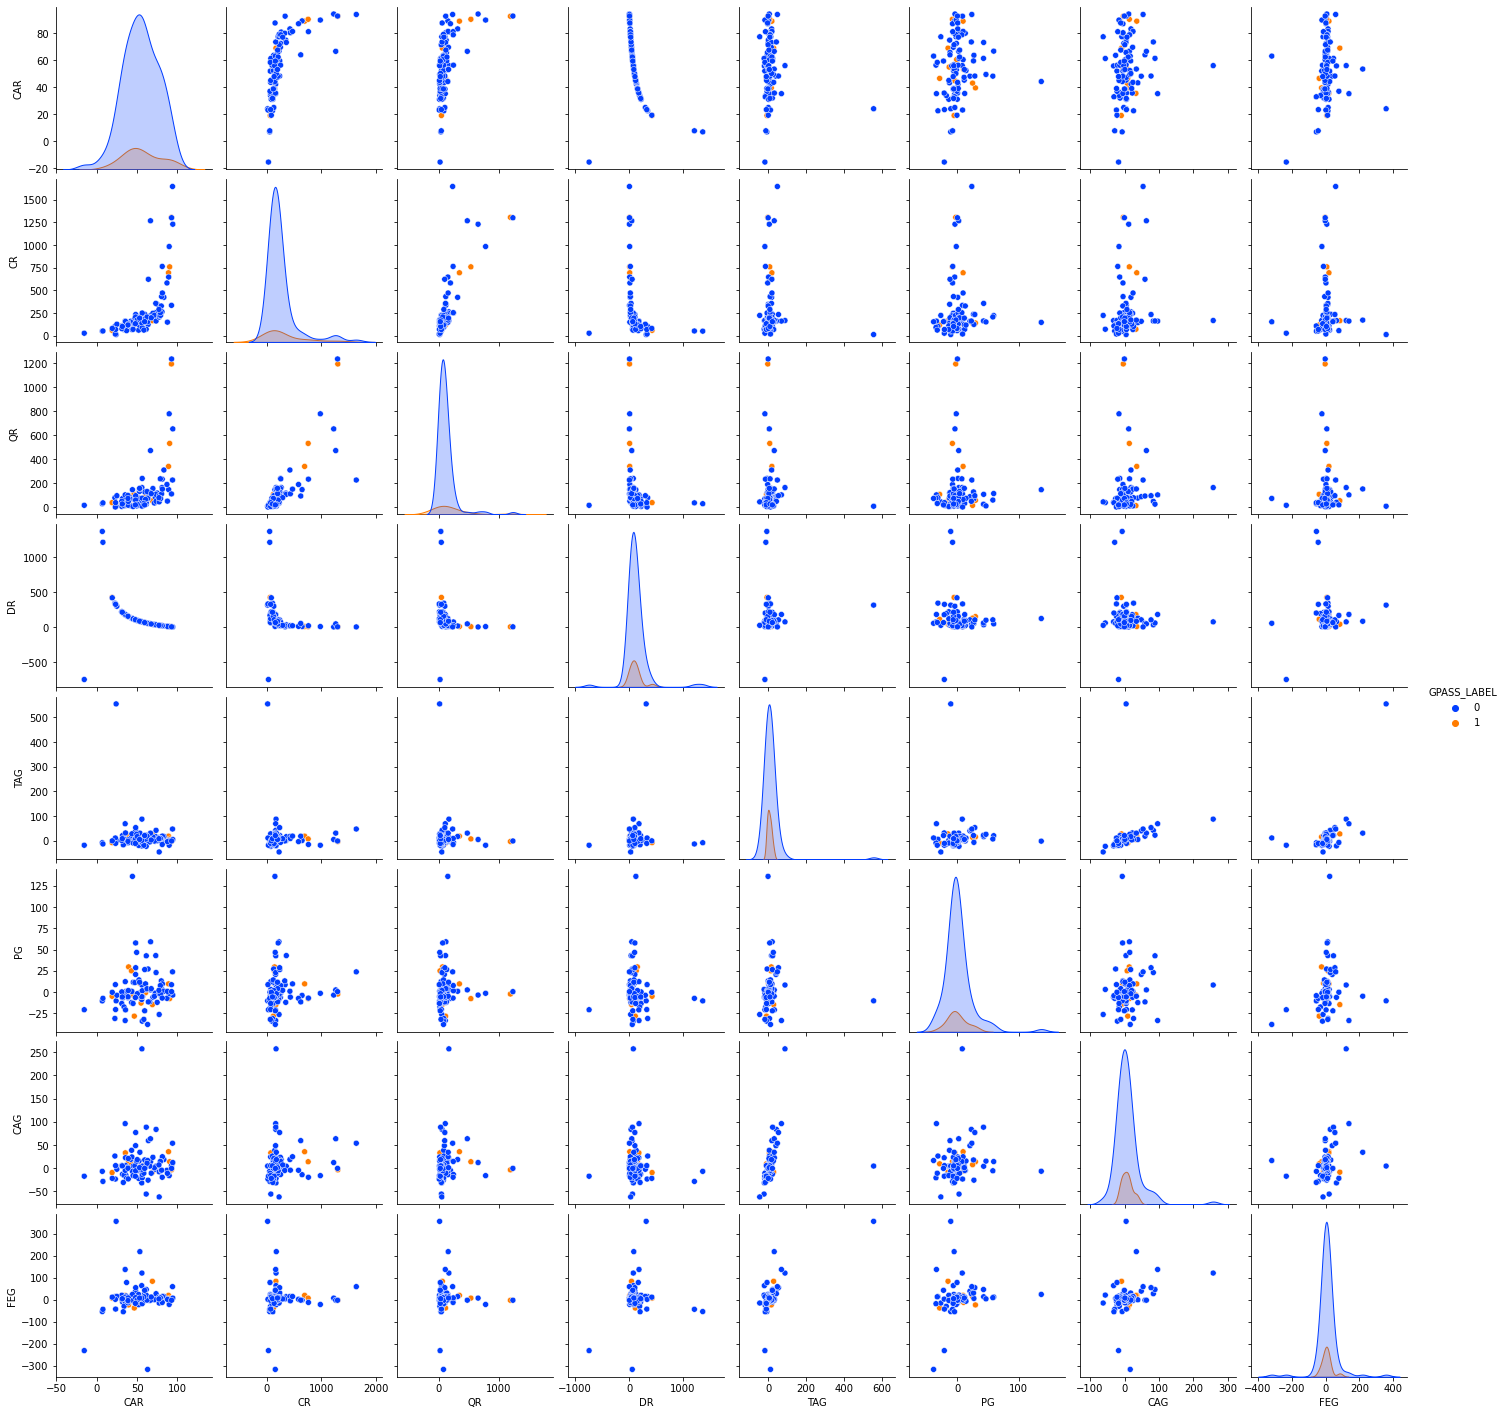

In [26]:
plt.figure(figsize=(15,15))
sns.pairplot(Combined_FS, hue='GPASS_LABEL', palette='bright')
plt.savefig("FS_ANALYSIS_SCATTERMATRIX.png", dpi=300)
plt.show()

## PCA(Principal Component Analysis)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [24]:
Combined_FS = Combined_FS.dropna(subset=['QR'])

In [25]:
x = Combined_FS.drop(['GPASS_LABEL'], axis=1).values
y = Combined_FS['GPASS_LABEL'].values

x = StandardScaler().fit_transform(x)
features = Combined_FS.columns.drop('GPASS_LABEL')
pd.DataFrame(x, columns=features)

,CAR,CR,QR,DR,TAG,PG,CAG,FEG
0,1.567944,1.450629,1.100709,-0.516753,0.124829,0.373515,0.768644,0.190969
1,0.251204,-0.124655,-0.155225,-0.256742,-0.062337,-0.100477,0.082872,-0.078698
2,-0.477792,-0.448697,-0.108908,0.029618,-0.256094,-0.222466,-0.507874,0.018940
3,-0.720780,-0.390671,-0.326456,0.175906,0.070144,1.283830,0.163739,-0.497909
4,1.632736,1.668768,2.070297,-0.525317,-0.072504,-0.415982,0.167147,-0.007024
...,...,...,...,...,...,...,...,...
97,1.743511,3.469285,5.627493,-0.539360,-0.219415,-0.042388,-0.230522,-0.160003
98,-0.332694,-0.418306,-0.522243,-0.042417,-0.392999,-0.358344,-0.700928,-0.386202
99,-1.083191,-0.518937,-0.481352,0.484408,-0.055184,-0.326263,-0.080157,-0.050237
100,-0.090163,-0.211892,0.177228,-0.143816,-0.109841,0.463306,-0.188509,-0.000722


In [33]:
FS_pca = PCA(n_components=2)
PCA_comps = FS_pca.fit_transform(x)
PCA_DF = pd.DataFrame(PCA_comps, columns=['pc1', 'pc2'])
PCA_DF

,pc1,pc2
0,2.508586,0.517308
1,0.066741,-0.090781
2,-0.637775,-0.394060
3,-0.709012,0.065260
4,3.046659,-0.158964
...,...,...
97,5.981954,-0.534280
98,-0.768621,-0.837022
99,-1.308361,-0.107092
100,-0.005240,-0.074767


In [34]:
FS_pca.explained_variance_ratio_

array([0.31633438, 0.23185826])

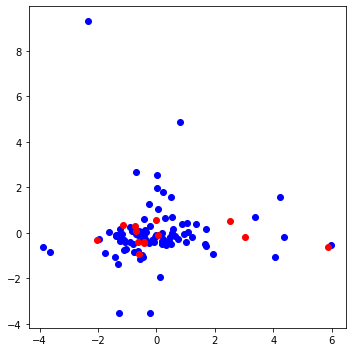

In [47]:
test = pd.concat([PCA_DF, pd.Series(y, name='label')], axis=1)
fig, ax = plt.subplots(figsize=(5,5))
ColorList = ['blue', 'red']
for l in [0, 1]:
    target = test[test['label']==l]
    ax.scatter(target['pc1'].values, target['pc2'].values, c=ColorList[l])

plt.tight_layout()
plt.show()

In [48]:
import plotly.express as px

In [81]:
Labels = np.where(y==1, 'GPASS', 'Non_GPASS')

In [80]:
pca = PCA(n_components=3)
components = pca.fit_transform(x)
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter_3d(components, x=0, y=1, z=2, color=Labels, title=f'Total Explained Variance: {total_var:.2f}%', labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
fig.update_traces(marker_size = 3)
fig.show()

In [78]:
pd.read_excel("fsdata/00864338_annual.xlsx")

,Unnamed: 0,"[D210000] Statement of financial position, current/non-current - Consolidated financial statements (Unit: KRW)",Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,20201231,20191231,20181231
0,NaN,concept_id,label_ko,label_en,class0,class1,class2,class3,"('연결재무제표',)","('연결재무제표',)","('연결재무제표',)"
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,ifrs-full_CurrentAssets,유동자산,Current assets,재무상태표 [abstract],자산 [abstract],유동자산,NaN,30902172993,29463001719,26879361054
3,1.0,ifrs-full_CashAndCashEquivalents,현금및현금성자산,Cash and cash equivalents,재무상태표 [abstract],자산 [abstract],유동자산,현금및현금성자산,10642254874,12751896086,11156965169
4,2.0,ifrs-full_TradeAndOtherCurrentReceivables,매출채권 및 기타유동채권,Trade and other current receivables,재무상태표 [abstract],자산 [abstract],유동자산,매출채권 및 기타유동채권,4115531900,3255674800,5226871383
5,3.0,ifrs-full_OtherCurrentFinancialAssets,기타유동금융자산,Other current financial assets,재무상태표 [abstract],자산 [abstract],유동자산,기타유동금융자산,2874607924,567310486,268934144
6,4.0,dart_OtherCurrentAssets,기타유동자산,Other current assets,재무상태표 [abstract],자산 [abstract],유동자산,기타유동자산,3155386430,2804867842,2118222413
7,5.0,ifrs-full_Inventories,재고자산,Inventories,재무상태표 [abstract],자산 [abstract],유동자산,재고자산,10114391865,10083252505,8108367945
8,6.0,ifrs-full_NoncurrentAssets,비유동자산,Non-current assets,재무상태표 [abstract],자산 [abstract],비유동자산,NaN,35980238233,39139444891,40170763837
9,7.0,ifrs-full_OtherNoncurrentFinancialAssets,기타비유동금융자산,Other non-current financial assets,재무상태표 [abstract],자산 [abstract],비유동자산,기타비유동금융자산,578195184,414333937,162712204
